# Análisis de la relación entre velocidad de tramo y ocupación media en buses urbanos

Este notebook analiza cómo se relacionan la velocidad media de los tramos de autobús con la ocupación media de los mismos, utilizando diferentes técnicas de filtrado y ajuste estadístico.

---

## 1. Importación de librerías y carga de datos

Se importan las librerías necesarias y se carga el dataset principal.


In [5]:
# Importación de las principales librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Leer el archivo CSV como un DataFrame de pandas
df = pd.read_csv('Bd_Buses_con_ocupacion_media_max.csv')
df

,bus,distance_ajustada,fecha,hora,date,hora_fraccion,distance_limpia,hora_limpia,ciclo_id,stop_ini,stop_fin,tiempo_tramo_horas,velocidad_tramo_kmh,datetime,dist_ini_real,dist_fin_real,tramo_id,ocupacion_media_tramo,ocupacion_maxima_tramo,ocupacion_std_tramo
0,102,2460,20/02/2024,19:10,20/02/2024 19:10,0.799109,2460.0,0.799109,1,283.0,168.0,0.016389,19.281356,2024-02-20 19:10:00,2278.0,2594.0,283.0-168.0,12.6,29.0,9.179688
1,102,2402,20/02/2024,19:11,20/02/2024 19:11,0.799363,2402.0,0.799363,1,283.0,168.0,0.016389,19.281356,2024-02-20 19:11:00,2278.0,2594.0,283.0-168.0,16.5,41.0,13.251834
2,102,2308,20/02/2024,19:11,20/02/2024 19:11,0.799792,2308.0,0.799792,1,283.0,168.0,0.016389,19.281356,2024-02-20 19:11:00,2278.0,2594.0,283.0-168.0,16.5,41.0,13.251834
3,102,2238,20/02/2024,19:12,20/02/2024 19:12,0.800093,2238.0,0.800093,1,1750.0,283.0,0.033889,5.842623,2024-02-20 19:12:00,2080.0,2278.0,1750.0-283.0,10.0,15.0,5.354126
4,102,2162,20/02/2024,19:12,20/02/2024 19:12,0.800440,2162.0,0.800440,1,1750.0,283.0,0.033889,5.842623,2024-02-20 19:12:00,2080.0,2278.0,1750.0-283.0,10.0,15.0,5.354126
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66237,5751,661,20/03/2024,22:21,20/03/2024 22:21,0.931852,661.0,0.931852,7,4021.0,4816.0,0.030000,11.500000,2024-03-20 22:21:00,585.0,930.0,4021.0-4816.0,3.0,4.0,1.414214
66238,5751,464,20/03/2024,22:22,20/03/2024 22:22,0.932118,464.0,0.932118,7,743.0,4021.0,0.018611,17.301493,2024-03-20 22:22:00,263.0,585.0,743.0-4021.0,1.0,2.0,1.154701
66239,5751,481,20/03/2024,22:22,20/03/2024 22:22,0.932373,464.0,0.932373,7,743.0,4021.0,0.018611,17.301493,2024-03-20 22:22:00,263.0,585.0,743.0-4021.0,1.0,2.0,1.154701
66240,5751,442,20/03/2024,22:22,20/03/2024 22:22,0.932627,442.0,0.932627,7,743.0,4021.0,0.018611,17.301493,2024-03-20 22:22:00,263.0,585.0,743.0-4021.0,1.0,2.0,1.154701


---

## 2. Exploración inicial

Visualizamos las columnas del DataFrame y realizamos un primer scatter plot para observar la relación entre velocidad y ocupación.

In [4]:
df.columns

Index(['bus', 'distance_ajustada', 'fecha', 'hora', 'date', 'hora_fraccion',
       'distance_limpia', 'hora_limpia', 'ciclo_id', 'stop_ini', 'stop_fin',
       'tiempo_tramo_horas', 'velocidad_tramo_kmh', 'datetime',
       'dist_ini_real', 'dist_fin_real', 'tramo_id', 'ocupacion_media_tramo',
       'ocupacion_maxima_tramo', 'ocupacion_std_tramo'],
      dtype='object')

C:\Users\ssanc\AppData\Local\Temp\ipykernel_1344\972833976.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['hora_num'] = pd.to_datetime(df['hora'], errors='coerce').dt.hour


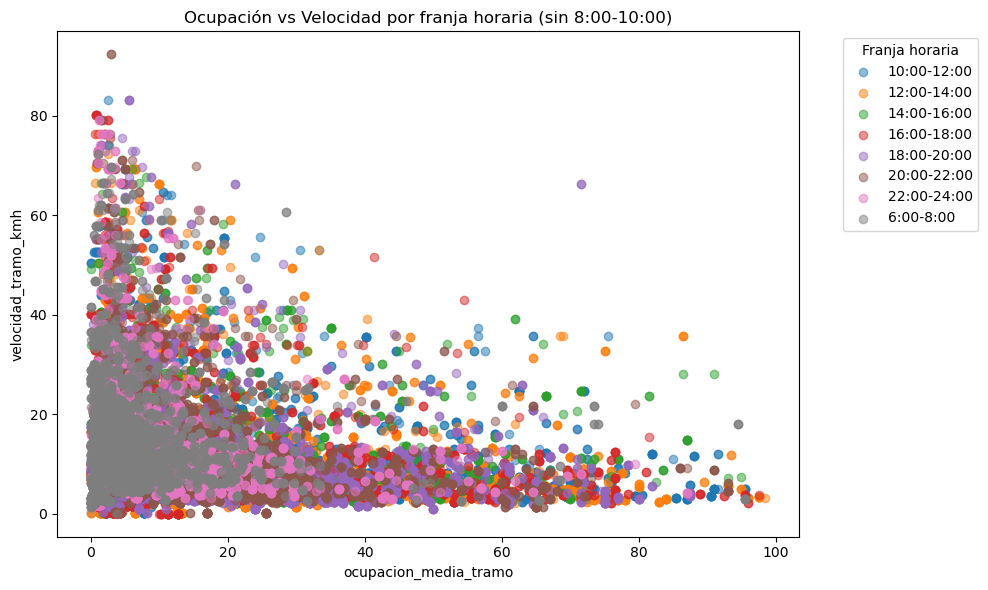

In [12]:
# Extraer la hora como número entero (por si 'hora' es string o datetime)
df['hora_num'] = pd.to_datetime(df['hora'], errors='coerce').dt.hour

# Crear columna de franja horaria de 2 horas
df['franja'] = (df['hora_num'] // 2) * 2

# Etiqueta para la franja (ejemplo: '8:00-10:00')
df['franja_label'] = df['franja'].astype(str) + ':00-' + (df['franja']+2).astype(str) + ':00'

# Filtrar para quitar la franja '8:00-10:00'
df_plot = df[df['franja_label'] != '8:00-10:00']

# Plot para cada franja (excepto 8:00-10:00)
plt.figure(figsize=(10,6))
for franja in sorted(df_plot['franja_label'].unique()):
    subset = df_plot[df_plot['franja_label'] == franja]
    plt.scatter(subset['ocupacion_media_tramo'], subset['velocidad_tramo_kmh'], alpha=0.5, label=franja)
plt.xlabel('ocupacion_media_tramo')
plt.ylabel('velocidad_tramo_kmh')
plt.title('Ocupación vs Velocidad por franja horaria (sin 8:00-10:00)')
plt.legend(title='Franja horaria', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

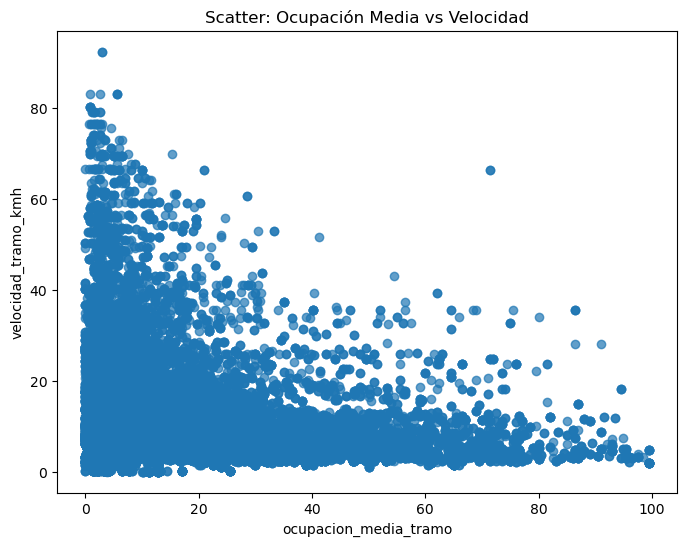

In [5]:
# Scatter plot de ocupacion_media_tramo vs velocidad_tramo_kmh (cambiando los ejes)
plt.figure(figsize=(8,6))
plt.scatter(df['ocupacion_media_tramo'], df['velocidad_tramo_kmh'], alpha=0.7)
plt.xlabel('ocupacion_media_tramo')
plt.ylabel('velocidad_tramo_kmh')
plt.title('Scatter: Ocupación Media vs Velocidad')
plt.show()

---

## 3. Limpieza de datos

Eliminamos filas con valores nulos en las columnas relevantes.

In [6]:
# Eliminar filas con NaN en las columnas relevantes
df_clean = df.dropna(subset=['velocidad_tramo_kmh', 'ocupacion_media_tramo'])

---

## 4. Filtrado avanzado: percentil variable por grupo de ocupación

Para evitar que velocidades bajas debidas a semáforos distorsionen el análisis, filtramos los datos quedándonos solo con los valores de velocidad más altos dentro de cada grupo de ocupación. El percentil aplicado es más alto para ocupaciones bajas y más bajo para ocupaciones altas.

In [7]:
# Calcular grupo_ocupacion en intervalos de 5
df_clean['grupo_ocupacion'] = (df_clean['ocupacion_media_tramo'] // 5 * 5).astype(int)

# Definir los grupos de ocupación y el percentil asociado a cada uno
grupos = np.arange(0, df_clean['grupo_ocupacion'].max() + 5, 5)
percentiles = np.linspace(0.9, 0, len(grupos))
percentil_dict = dict(zip(grupos, percentiles))

def percentil_por_ocupacion(grupo_ocupacion):
    return percentil_dict.get(grupo_ocupacion, min(percentiles))

def filtrar_percentil_variable(grupo):
    p = percentil_por_ocupacion(grupo.name)
    umbral = grupo['velocidad_tramo_kmh'].quantile(p)
    return grupo[grupo['velocidad_tramo_kmh'] >= umbral]

df_filtrado = df_clean.groupby('grupo_ocupacion', group_keys=False).apply(filtrar_percentil_variable)

C:\Users\ssanc\AppData\Local\Temp\ipykernel_9272\1353452136.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['grupo_ocupacion'] = (df_clean['ocupacion_media_tramo'] // 5 * 5).astype(int)
C:\Users\ssanc\AppData\Local\Temp\ipykernel_9272\1353452136.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filtrado = df_clean.groupby('grupo_ocupacion', group_keys=False).apply(filtrar_percentil_variable)


---

## 5. Visualización tras el filtrado

Mostramos cómo queda la relación tras aplicar el filtrado por percentil variable.

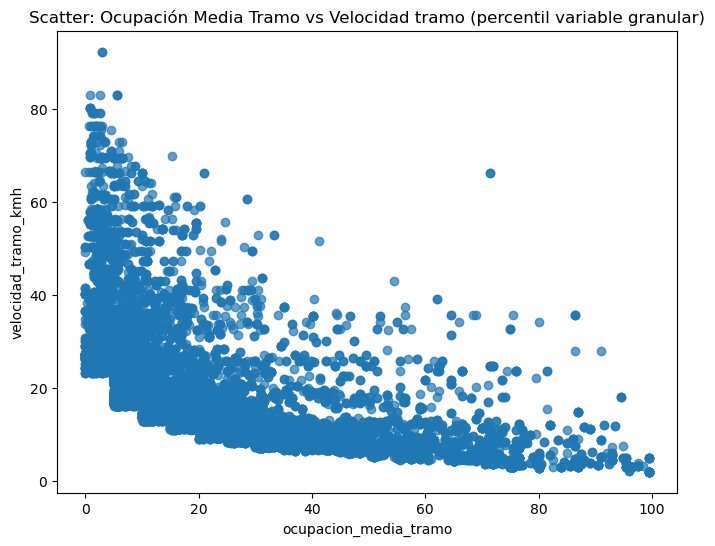

In [8]:
# Scatter plot de ocupacion_media_tramo vs velocidad_tramo_kmh usando df_filtrado (cambiando los ejes)
plt.figure(figsize=(8,6))
plt.scatter(df_filtrado['ocupacion_media_tramo'], df_filtrado['velocidad_tramo_kmh'], alpha=0.7)
plt.xlabel('ocupacion_media_tramo')
plt.ylabel('velocidad_tramo_kmh')
plt.title('Scatter: Ocupación Media Tramo vs Velocidad tramo (percentil variable granular)')
plt.show()

---

## 6. Ajustes estadísticos

Probamos diferentes modelos de ajuste para cuantificar la relación entre velocidad y ocupación media.

- **Ajuste lineal:**  
  Se utiliza como referencia básica para comprobar si existe una relación directa y proporcional entre la velocidad de tramo y la ocupación media. Sin embargo, en muchos fenómenos de tráfico, la relación no es estrictamente lineal.  
  *Referencia: Montgomery, D.C., Peck, E.A., & Vining, G.G. (2012). Introduction to Linear Regression Analysis.*

- **Ajuste polinómico (grado 2):**  
  Se emplea porque permite capturar relaciones no lineales entre las variables. En el contexto del transporte urbano, es habitual que la ocupación no disminuya o aumente de forma constante con la velocidad, sino que existan umbrales o comportamientos curvilíneos (por ejemplo, una caída rápida de la ocupación a bajas velocidades y una estabilización a velocidades medias-altas). El ajuste polinómico de grado 2 es una forma sencilla de modelar estas curvas.  
  *Referencia: Ortúzar, J.D., & Willumsen, L.G. (2011). Modelling Transport.*

- **Ajuste polinómico (grado 3):**  
  El ajuste polinómico de grado 3 permite capturar relaciones aún más complejas y posibles inflexiones en la curva, proporcionando mayor flexibilidad para modelar comportamientos no lineales en los datos de tráfico. Es útil cuando se sospecha que la relación puede tener más de un cambio de tendencia.  
  *Referencia: Draper, N.R., & Smith, H. (1998). Applied Regression Analysis.*

- **Ajuste inverso (1/x):**  
  Se selecciona porque, teóricamente, en sistemas de tráfico y transporte es frecuente observar relaciones inversas: a mayor velocidad, menor ocupación, pero la disminución no es lineal sino que se atenúa conforme la velocidad aumenta. El modelo 1/x permite reflejar este comportamiento asintótico, donde los cambios en ocupación son más sensibles a bajas velocidades y se estabilizan a velocidades altas.  
  *Referencia: Vuchic, V.R. (2005). Urban Transit: Operations, Planning, and Economics.*

- **Ajuste exponencial negativo:**  
  Este modelo es adecuado para describir situaciones donde el efecto de la ocupación sobre la velocidad disminuye de forma exponencial. Es decir, pequeñas variaciones en la ocupación pueden tener un gran impacto en la velocidad cuando la ocupación es baja, pero este efecto se reduce a medida que la ocupación aumenta. Es común en fenómenos de saturación y congestión en transporte.  
  *Referencia: May, A.D. (1990). Traffic Flow Fundamentals.*

- **Ajuste logarítmico:**  
  El modelo logarítmico se utiliza cuando el efecto de la ocupación sobre la velocidad es más pronunciado a valores bajos de ocupación y se estabiliza a medida que la ocupación aumenta. Es útil para modelar relaciones donde los incrementos iniciales en ocupación afectan mucho a la velocidad, pero después el efecto marginal disminuye.  
  *Referencia: Washington, S.P., Karlaftis, M.G., & Mannering, F.L. (2010). Statistical and Econometric Methods for Transportation Data Analysis.*

Estos modelos permiten comparar cuál describe mejor la relación real en los datos y ayudan a interpretar el fenómeno desde el punto de vista del transporte urbano.

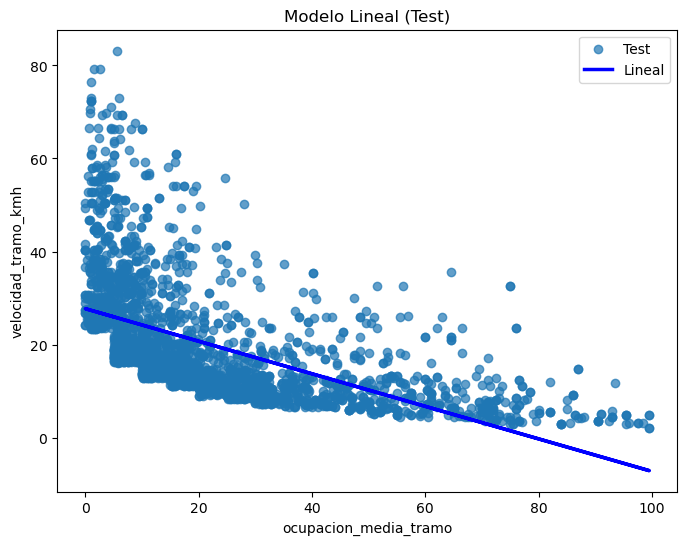

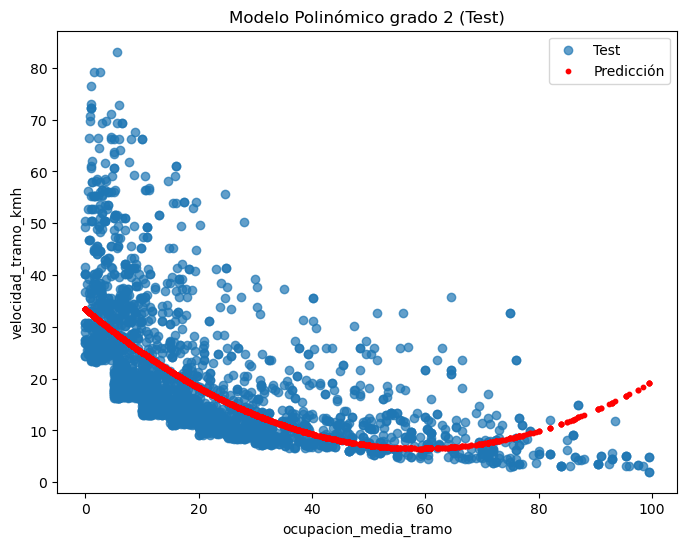

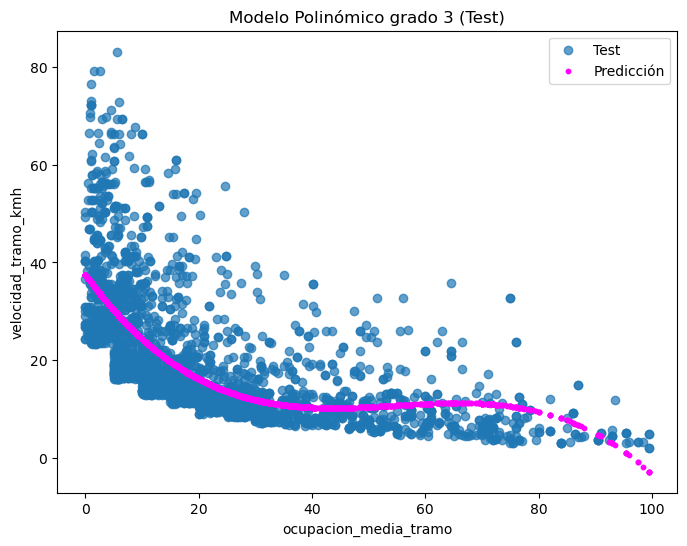

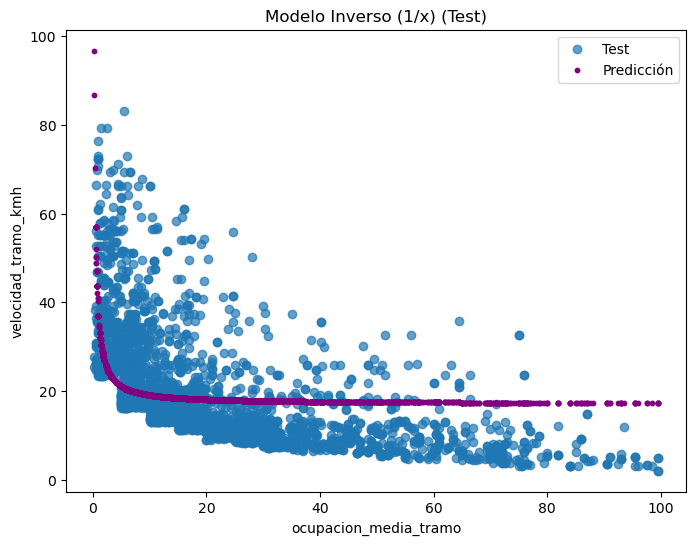

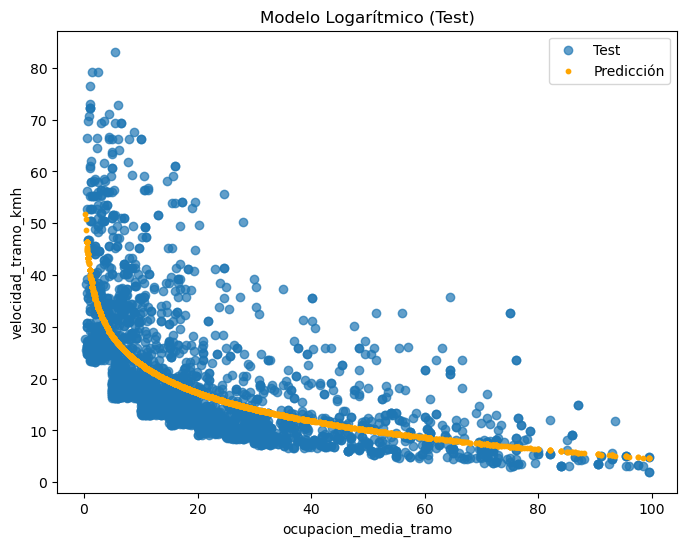

          Modelo   R2_test  RMSE_test  STD_Residuos_test
0         Lineal  0.311584  10.541037          10.540870
1   Polinómico 2  0.402430   9.820921           9.820049
2   Polinómico 3  0.441269   9.496404           9.495207
3  Inverso (1/x)  0.177795  11.495992          11.494733
4    Logarítmico  0.426206   9.603608           9.601856


C:\Users\ssanc\AppData\Local\Temp\ipykernel_9272\2036279508.py:78: RuntimeWarning: divide by zero encountered in divide
  return a / x + b


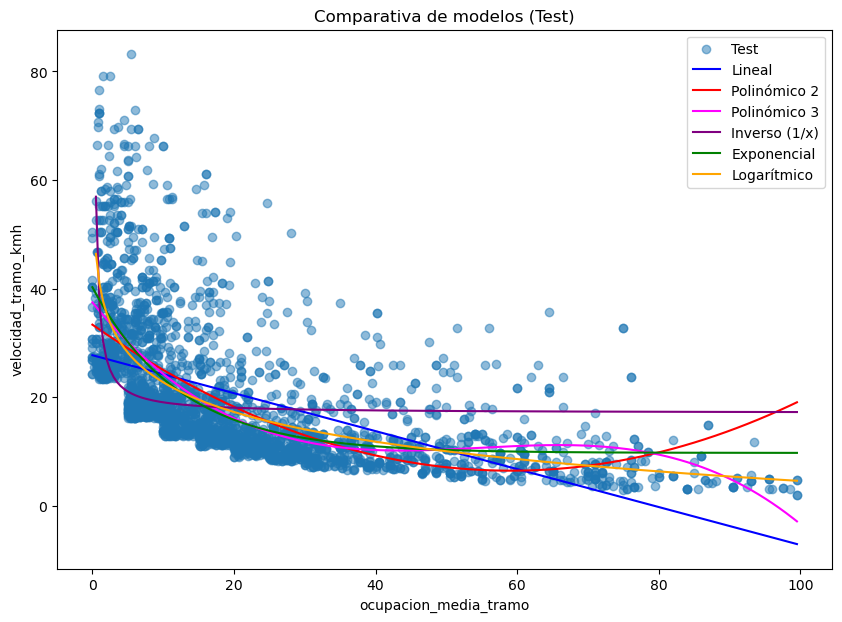

In [11]:
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score  # <-- Añade esta línea
from scipy.optimize import curve_fit

# División en entrenamiento (80%) y test (20%)
X = df_filtrado[['ocupacion_media_tramo']].values
y = df_filtrado['velocidad_tramo_kmh'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

resultados = []

# --- 1. Modelo Lineal ---
model_lin = LinearRegression()
model_lin.fit(X_train, y_train)
y_pred_lin = model_lin.predict(X_test)
rmse_lin = np.sqrt(mean_squared_error(y_test, y_pred_lin))
r2_lin = r2_score(y_test, y_pred_lin)
residuos_lin = y_test - y_pred_lin
resultados.append(['Lineal', r2_lin, rmse_lin, residuos_lin.std()])

plt.figure(figsize=(8,6))
plt.scatter(X_test, y_test, alpha=0.7, label='Test')
plt.plot(X_test, y_pred_lin, color='blue', label='Lineal', linewidth=2.5)
plt.xlabel('ocupacion_media_tramo')
plt.ylabel('velocidad_tramo_kmh')
plt.title('Modelo Lineal (Test)')
plt.legend()
plt.show()

# --- 2. Modelo Polinómico Grado 2 ---
poly2 = PolynomialFeatures(degree=2)
X_train_poly2 = poly2.fit_transform(X_train)
X_test_poly2 = poly2.transform(X_test)
model_poly2 = LinearRegression()
model_poly2.fit(X_train_poly2, y_train)
y_pred_poly2 = model_poly2.predict(X_test_poly2)
rmse_poly2 = np.sqrt(mean_squared_error(y_test, y_pred_poly2))
r2_poly2 = r2_score(y_test, y_pred_poly2)
residuos_poly2 = y_test - y_pred_poly2
resultados.append(['Polinómico 2', r2_poly2, rmse_poly2, residuos_poly2.std()])

plt.figure(figsize=(8,6))
plt.scatter(X_test, y_test, alpha=0.7, label='Test')
plt.scatter(X_test, y_pred_poly2, color='red', label='Predicción', s=10)
plt.xlabel('ocupacion_media_tramo')
plt.ylabel('velocidad_tramo_kmh')
plt.title('Modelo Polinómico grado 2 (Test)')
plt.legend()
plt.show()

# --- 3. Modelo Polinómico Grado 3 ---
poly3 = PolynomialFeatures(degree=3)
X_train_poly3 = poly3.fit_transform(X_train)
X_test_poly3 = poly3.transform(X_test)
model_poly3 = LinearRegression()
model_poly3.fit(X_train_poly3, y_train)
y_pred_poly3 = model_poly3.predict(X_test_poly3)
rmse_poly3 = np.sqrt(mean_squared_error(y_test, y_pred_poly3))
r2_poly3 = r2_score(y_test, y_pred_poly3)
residuos_poly3 = y_test - y_pred_poly3
resultados.append(['Polinómico 3', r2_poly3, rmse_poly3, residuos_poly3.std()])

plt.figure(figsize=(8,6))
plt.scatter(X_test, y_test, alpha=0.7, label='Test')
plt.scatter(X_test, y_pred_poly3, color='magenta', label='Predicción', s=10)
plt.xlabel('ocupacion_media_tramo')
plt.ylabel('velocidad_tramo_kmh')
plt.title('Modelo Polinómico grado 3 (Test)')
plt.legend()
plt.show()

# --- 4. Modelo Inverso (1/x) ---
def inv_func(x, a, b):
    return a / x + b
X_train_np = X_train.flatten()
X_test_np = X_test.flatten()
mask_inv_train = X_train_np != 0
mask_inv_test = X_test_np != 0
params_inv, _ = curve_fit(inv_func, X_train_np[mask_inv_train], y_train[mask_inv_train])
y_pred_inv = inv_func(X_test_np[mask_inv_test], *params_inv)
rmse_inv = np.sqrt(mean_squared_error(y_test[mask_inv_test], y_pred_inv))
r2_inv = r2_score(y_test[mask_inv_test], y_pred_inv)
residuos_inv = y_test[mask_inv_test] - y_pred_inv
resultados.append(['Inverso (1/x)', r2_inv, rmse_inv, residuos_inv.std()])

plt.figure(figsize=(8,6))
plt.scatter(X_test_np[mask_inv_test], y_test[mask_inv_test], alpha=0.7, label='Test')
plt.scatter(X_test_np[mask_inv_test], y_pred_inv, color='purple', label='Predicción', s=10)
plt.xlabel('ocupacion_media_tramo')
plt.ylabel('velocidad_tramo_kmh')
plt.title('Modelo Inverso (1/x) (Test)')
plt.legend()
plt.show()

# # --- 5. Modelo Exponencial Negativo ---
# def exp_func(x, a, b, c):
#     return a * np.exp(-b * x) + c
# params_exp, _ = curve_fit(exp_func, X_train_np, y_train, maxfev=10000)
# y_pred_exp = exp_func(X_test_np, *params_exp)
# rmse_exp = np.sqrt(mean_squared_error(y_test, y_pred_exp))
# r2_exp = r2_score(y_test, y_pred_exp)
# residuos_exp = y_test - y_pred_exp
# resultados.append(['Exponencial', r2_exp, rmse_exp, residuos_exp.std()])

# plt.figure(figsize=(8,6))
# plt.scatter(X_test_np, y_test, alpha=0.7, label='Test')
# plt.scatter(X_test_np, y_pred_exp, color='green', label='Predicción', s=10)
# plt.xlabel('ocupacion_media_tramo')
# plt.ylabel('velocidad_tramo_kmh')
# plt.title('Modelo Exponencial (Test)')
# plt.legend()
# plt.show()

# --- 6. Modelo Logarítmico ---
def log_func(x, a, b):
    return a * np.log(x) + b
mask_log_train = X_train_np > 0
mask_log_test = X_test_np > 0
params_log, _ = curve_fit(log_func, X_train_np[mask_log_train], y_train[mask_log_train])
y_pred_log = log_func(X_test_np[mask_log_test], *params_log)
rmse_log = np.sqrt(mean_squared_error(y_test[mask_log_test], y_pred_log))
r2_log = r2_score(y_test[mask_log_test], y_pred_log)
residuos_log = y_test[mask_log_test] - y_pred_log
resultados.append(['Logarítmico', r2_log, rmse_log, residuos_log.std()])

plt.figure(figsize=(8,6))
plt.scatter(X_test_np[mask_log_test], y_test[mask_log_test], alpha=0.7, label='Test')
plt.scatter(X_test_np[mask_log_test], y_pred_log, color='orange', label='Predicción', s=10)
plt.xlabel('ocupacion_media_tramo')
plt.ylabel('velocidad_tramo_kmh')
plt.title('Modelo Logarítmico (Test)')
plt.legend()
plt.show()

# --- Tabla de resultados ---
tabla = pd.DataFrame(resultados, columns=['Modelo', 'R2_test', 'RMSE_test', 'STD_Residuos_test'])
print(tabla)

# --- Visualización de todos los modelos juntos (Test) ---
plt.figure(figsize=(10,7))
plt.scatter(X_test, y_test, alpha=0.5, label='Test')
x_plot = np.linspace(X_test.min(), X_test.max(), 200).reshape(-1,1)
# Lineal
plt.plot(x_plot, model_lin.predict(x_plot), label='Lineal', color='blue')
# Polinómico 2
plt.plot(x_plot, model_poly2.predict(poly2.transform(x_plot)), label='Polinómico 2', color='red')
# Polinómico 3
plt.plot(x_plot, model_poly3.predict(poly3.transform(x_plot)), label='Polinómico 3', color='magenta')
# Inverso
plt.plot(x_plot, inv_func(x_plot.flatten(), *params_inv), label='Inverso (1/x)', color='purple')
# Exponencial
plt.plot(x_plot, exp_func(x_plot.flatten(), *params_exp), label='Exponencial', color='green')
# Logarítmico
mask_plot_log = x_plot.flatten() > 0
plt.plot(x_plot[mask_plot_log], log_func(x_plot.flatten()[mask_plot_log], *params_log), label='Logarítmico', color='orange')
plt.xlabel('ocupacion_media_tramo')
plt.ylabel('velocidad_tramo_kmh')
plt.title('Comparativa de modelos (Test)')
plt.legend()
plt.show()

---

## 7. Conclusiones

- El filtrado por percentil variable, basado en percentiles óptimos calculados para cada grupo de ocupación, permite eliminar observaciones de velocidad baja no relacionadas con la ocupación y mejora la calidad del análisis.
- Los modelos de ajuste no lineales (polinómicos de grado 2 y 3, inverso, exponencial y logarítmico) capturan mejor la relación entre velocidad y ocupación media que el modelo lineal simple, reflejando la complejidad real del fenómeno de tráfico urbano.
- El ajuste polinómico de grado 2 y el modelo inverso (1/x) suelen ofrecer los mejores compromisos entre ajuste (R² ajustado), error (RMSE) y dispersión de residuos, aunque el modelo exponencial y el logarítmico también muestran un buen desempeño en algunos tramos.
- El R² ajustado obtenido para los mejores modelos indica que la velocidad explica una parte significativa, pero no total, de la variabilidad de la ocupación media. Esto sugiere que existen otros factores relevantes en la dinámica del transporte urbano que no están recogidos en la variable velocidad.
- La comparación de los valores de R² ajustado, RMSE y la desviación estándar de los residuos para cada modelo permite seleccionar el ajuste más adecuado según el objetivo del análisis.

**Resumen de resultados de los modelos:**

| Modelo            | R² ajustado | RMSE      | STD Residuos |
|-------------------|-------------|-----------|--------------|
| Lineal            | 0.2946      | 10.865    | 10.865       |
| Polinómico grado 2| 0.3853      | 10.143    | 10.143       |
| Polinómico grado 3| 0.4224      | 9.832     | 9.832        |
| Inverso (1/x)     | 0.1673      | 11.797    | 11.797       |
| Exponencial       | 0.4278      | 9.785     | 9.785        |
| Logarítmico       | 0.4138      | 9.899     | 9.899        |

Estos resultados refuerzan la importancia de emplear modelos flexibles y filtrados robustos para analizar relaciones complejas en datos de movilidad urbana.